In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
import time

In [2]:
from plot_functions import plot_results
from plot_functions import plot_results_by_month
from plot_functions import plot_results_with_uncertainty
from plot_functions import plot_results_with_uncertainty_by_month
from helpers import day_ahead_forecast
from helpers import forecast_mean
from helpers import prepare_features
from helpers import compute_picp_pinaw

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

In [4]:
forecast_horizon = 24

In [5]:
file_path = os.path.join(current_directory, 'data_augmented/X_train.npy')
X_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/y_train.npy')
y_train = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_train.csv')
timestamps_train = pd.read_csv(file_path, parse_dates=True).rename({'0' :'timestamps'})
timestamps_train.rename(columns={'0': 'timestamps'}, inplace=True)
timestamps_train = pd.to_datetime(timestamps_train['timestamps'])
file_path = os.path.join(current_directory, 'data_augmented/X_test.npy')
X_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/y_test.npy')
y_test = np.load(file_path)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_test.csv')
timestamps_test = pd.read_csv(file_path, parse_dates=True).rename({'0' :'timestamps'})
timestamps_test.rename(columns={'0': 'timestamps'}, inplace=True)
timestamps_test = pd.to_datetime(timestamps_test['timestamps'])

In [6]:
import torch

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


In [7]:
import torch.nn as nn

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


### LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer for multi-step forecasting

    def forward(self, x):
        # LSTM forward pass
        output, _ = self.lstm(x)
        # Take the last hidden state for forecasting
        last_hidden = output[:, -1, :]
        y = self.fc(last_hidden)
        return y
    
    def enable_mc_dropout(self):
        """Enable MC Dropout by setting all dropout layers to train mode."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

### LSTM Training
# Initialize the LSTM Model
input_size = X_train.shape[2]  # Number of features per time step
output_size = y_train.shape[1]  # Forecast horizon (24 hours)
hidden_size = 64  # Number of hidden units
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.3

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)

learning_rate = 1e-3
weight_decay = 1e-4  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Early stopping parameters
patience_limit = 5
best_val_loss = float("inf")
patience_counter = 0

# Training loop with early stopping
num_epochs = 50  # Increased epochs to allow for early stopping
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print training metrics
    epoch_loss /= len(train_loader)
    end_time = time.time()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

    # Early stopping logic
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor.to(device))
        val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()

    print(f"Validation Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'hidden_size': hidden_size,
            'output_size': output_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'X_train_tensor': X_train_tensor.cpu(),
            'X_test_tensor': X_test_tensor.cpu(),
            'y_train_tensor': y_train_tensor.cpu(),
            'y_test_tensor': y_test_tensor.cpu(),
            'batch_size': batch_size,
        }, "best_lstm_model_and_data.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break

# Test the model
checkpoint = torch.load("best_lstm_model_and_data.pth")
model.load_state_dict(checkpoint['model_state_dict'])  # Load the best model
model.eval()

# Evaluate on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

Epoch 1, Loss: 0.3556, Time: 153.13 seconds
Validation Loss: 0.2541
Epoch 2, Loss: 0.2298, Time: 75.57 seconds
Validation Loss: 0.2335
Epoch 3, Loss: 0.2016, Time: 34.64 seconds
Validation Loss: 0.2130
Epoch 4, Loss: 0.1811, Time: 36.35 seconds
Validation Loss: 0.1677
Epoch 5, Loss: 0.1622, Time: 39.90 seconds
Validation Loss: 0.1732
Epoch 6, Loss: 0.1463, Time: 39.50 seconds
Validation Loss: 0.1358
Epoch 7, Loss: 0.1310, Time: 39.28 seconds
Validation Loss: 0.1161
Epoch 8, Loss: 0.1306, Time: 39.44 seconds
Validation Loss: 0.1181
Epoch 9, Loss: 0.1175, Time: 39.71 seconds
Validation Loss: 0.1209
Epoch 10, Loss: 0.1111, Time: 40.16 seconds
Validation Loss: 0.1361
Epoch 11, Loss: 0.1099, Time: 34.87 seconds
Validation Loss: 0.1394
Epoch 12, Loss: 0.1163, Time: 34.70 seconds
Validation Loss: 0.1476
Early stopping triggered.
Test Loss: 0.1161


In [8]:
test_predictions_np = test_predictions.cpu().detach().numpy()  # Predictions, size: (num_test_samples, forecast_horizon)
y_test_np = y_test_tensor.cpu().numpy()  # Ground truth, size: (num_test_samples, forecast_horizon)

In [9]:
num_samples, forecast_horizon = test_predictions_np.shape  
prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0, num_samples+forecast_horizon-1)]

In [10]:
predictions = day_ahead_forecast(test_predictions_np, prediction_timestamps)
actuals = day_ahead_forecast(y_test_np, prediction_timestamps)

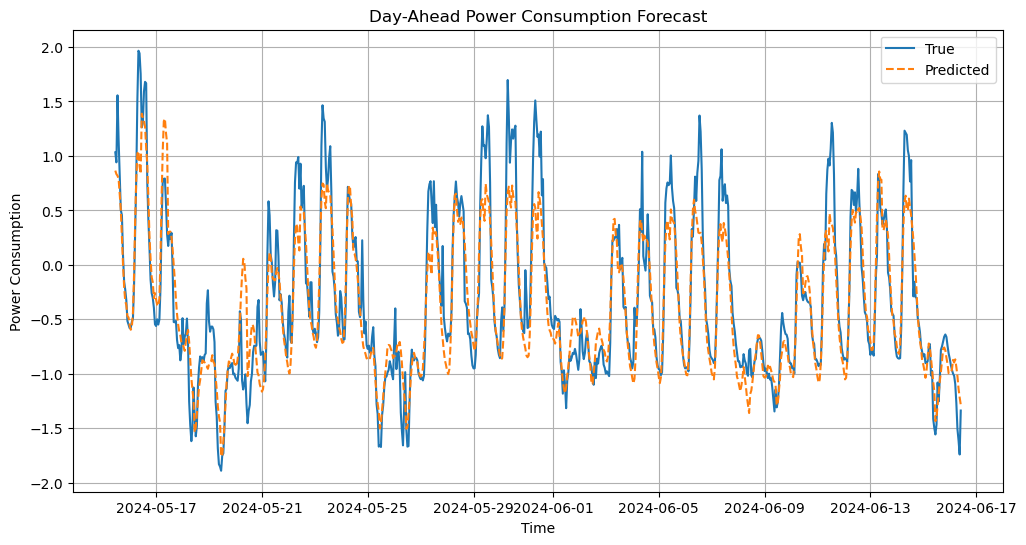

In [11]:
plot_results(predictions, actuals, "Day-Ahead Power Consumption Forecast")

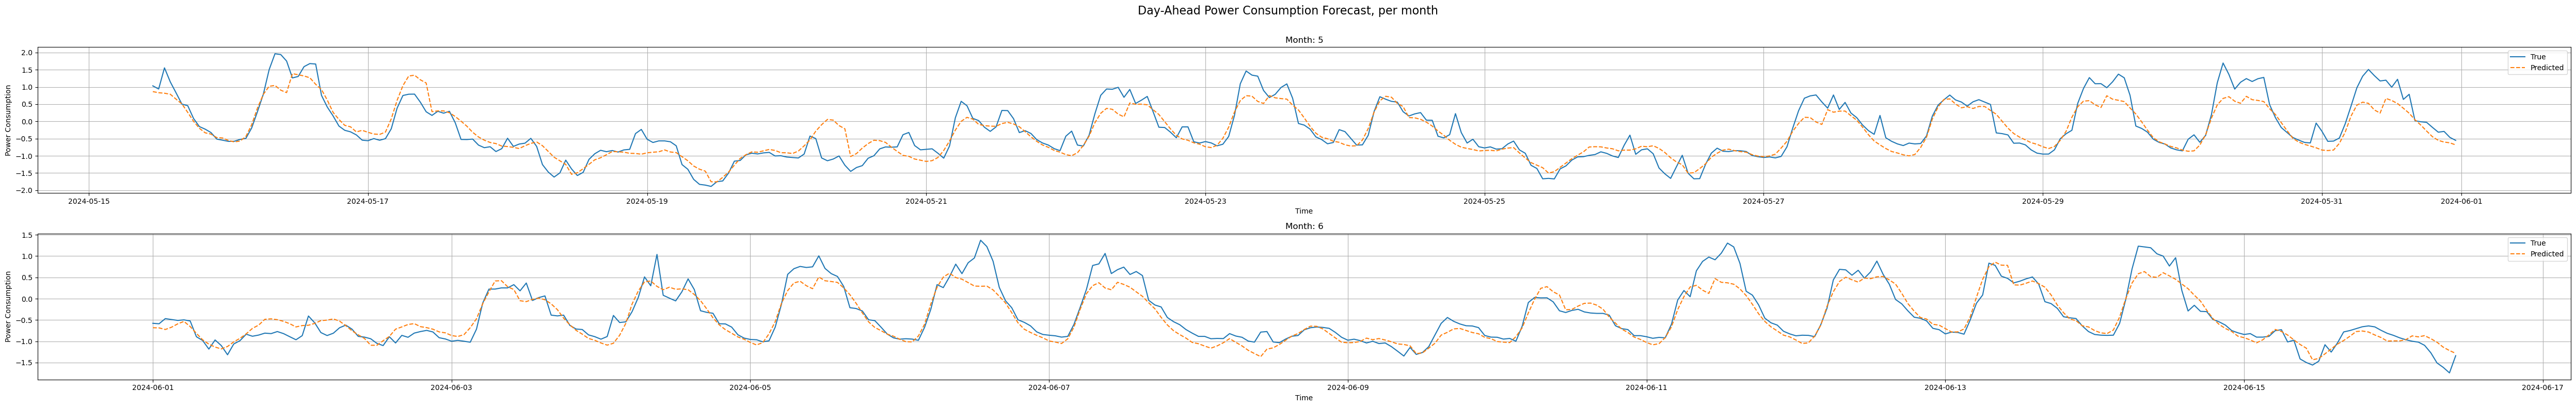

In [12]:
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month")

In [13]:
predictions = forecast_mean(test_predictions_np, prediction_timestamps)
actuals = forecast_mean(y_test_np, prediction_timestamps)

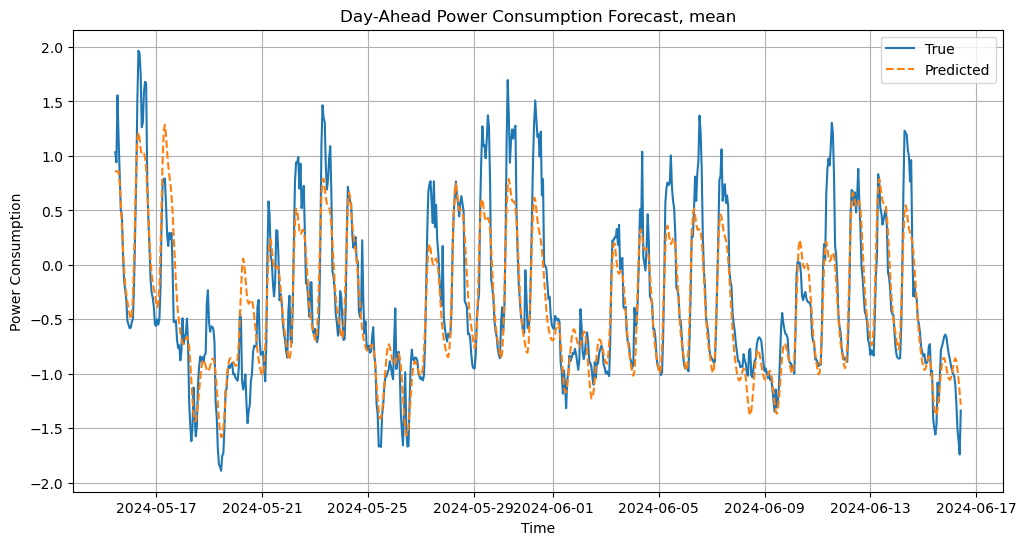

In [14]:
plot_results(predictions, actuals, "Day-Ahead Power Consumption Forecast, mean")

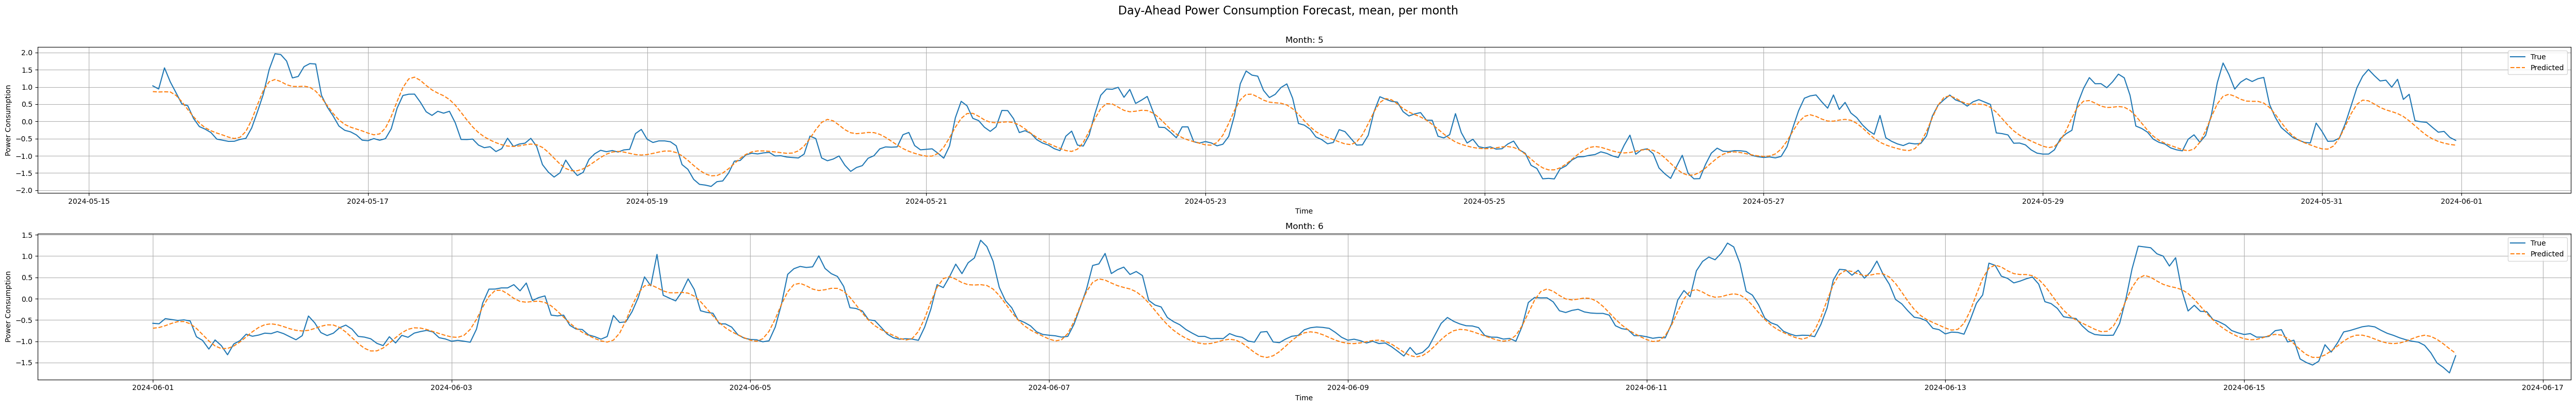

In [15]:
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, mean, per month")

In [16]:
# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [17]:
models = ['TCN prediction at 10 am', 'TCN predictions at all time steps']
error_dict = {'model': models,
              'RMSE': np.zeros(len(models)),
              'MAE': np.zeros(len(models)),
              'ME': np.zeros(len(models)),
              'MAPE': np.zeros(len(models))
    }
predictions_evaluation = pd.DataFrame(error_dict).set_index("model")

In [18]:
predictions_evaluation.loc[models[0], 'RMSE'] = root_mean_squared_error(actuals, predictions)
predictions_evaluation.loc[models[0], 'MAE'] = mean_absolute_error(actuals, predictions)
predictions_evaluation.loc[models[0], 'ME'] = max_error(actuals, predictions)
predictions_evaluation.loc[models[0], 'MAPE'] = mean_absolute_percentage_error(actuals, predictions)

In [19]:
y_pred = test_predictions_np
y_true = y_test_np
predictions_evaluation.loc[models[1], 'RMSE'] = root_mean_squared_error(y_true.flatten(), y_pred.flatten())
predictions_evaluation.loc[models[1], 'MAE'] = mean_absolute_error(y_true.flatten(), y_pred.flatten())
predictions_evaluation.loc[models[1], 'ME'] = max_error(y_true.flatten(), y_pred.flatten())
predictions_evaluation.loc[models[1], 'MAPE'] = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
predictions_evaluation

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.32454,0.23173,1.21529,0.63308
TCN predictions at all time steps,0.34080,0.24333,1.35923,0.70087


In [20]:
predictions_evaluation / np.max(predictions_evaluation, axis = 0)

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.95228,0.95230,0.89410,0.90327
TCN predictions at all time steps,1.00000,1.00000,1.00000,1.00000


## Monte Carlo Dropout

In [22]:
def monte_carlo_predictions(model, X, num_samples=100):
    """
    Perform Monte Carlo Dropout predictions.

    Parameters:
        model (nn.Module): TCN model with MC Dropout enabled.
        X (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_features).
        num_samples (int): Number of MC samples.

    Returns:
        torch.Tensor: Mean predictions.
        torch.Tensor: Prediction standard deviations (uncertainty).
    """
    model.enable_mc_dropout()  # Enable dropout during testing
    predictions = []

    for _ in range(num_samples):
        with torch.no_grad():
            predictions.append(model(X))  # Append prediction for each MC sample

    predictions = torch.stack(predictions)  # Shape: (num_samples, batch_size, output_size)
    mean_prediction = predictions.mean(dim=0)  # Mean over MC samples
    uncertainty = predictions.std(dim=0)  # Std dev over MC samples

    return mean_prediction, uncertainty

In [56]:
# Load the saved model and data
checkpoint = torch.load("best_lstm_model_and_data.pth")

# Recreate the model
model = LSTMModel(
    checkpoint['input_size'],
    checkpoint['hidden_size'],
    checkpoint['output_size'],
    checkpoint['num_layers'],
    checkpoint['dropout_rate']).to(device)

# Load the model state dict
model.load_state_dict(checkpoint['model_state_dict'])

# Ensure tensors are on the correct device
X_test_tensor = checkpoint['X_test_tensor'].to(device)
y_test_tensor = checkpoint['y_test_tensor'].to(device)

# Enable MC Dropout
model.enable_mc_dropout()

# Use MC Dropout for predictions
num_samples = 100  # Number of Monte Carlo samples
mean_predictions, uncertainties = monte_carlo_predictions(model, X_test_tensor, num_samples)

# Compute test loss using the mean predictions
criterion = nn.MSELoss()
test_loss = criterion(mean_predictions, y_test_tensor).item()
print(f"Test Loss (MC Dropout): {test_loss:.4f}")

# Convert results to numpy for further analysis
mean_predictions_np = mean_predictions.cpu().numpy()
uncertainties_np = uncertainties.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

Test Loss (MC Dropout): 0.1151


In [57]:
mean_predictions = day_ahead_forecast(mean_predictions_np, prediction_timestamps)
uncertainties = day_ahead_forecast(uncertainties_np, prediction_timestamps)
actuals = day_ahead_forecast(y_true, prediction_timestamps)

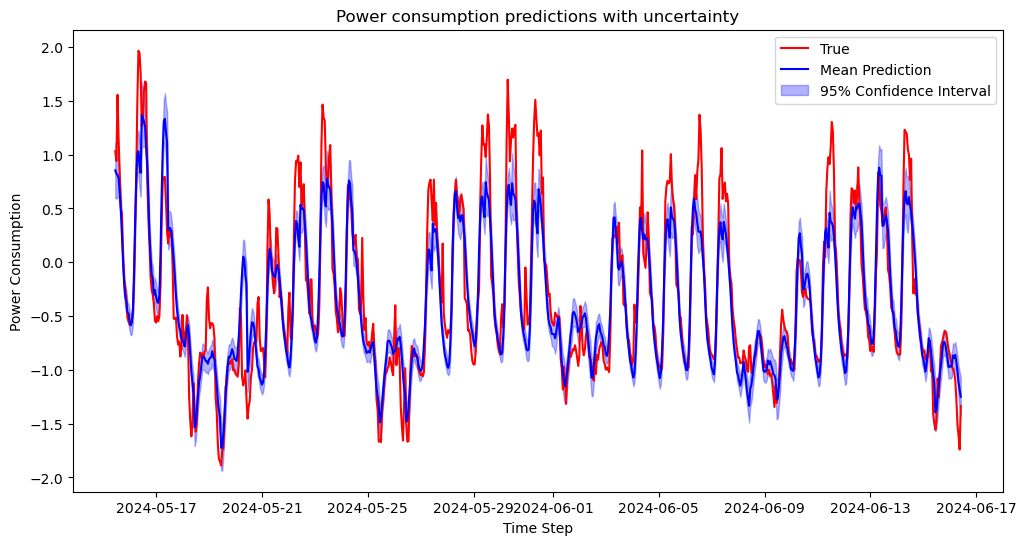

In [58]:
confidence_level = 1.96
plot_results_with_uncertainty(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty')

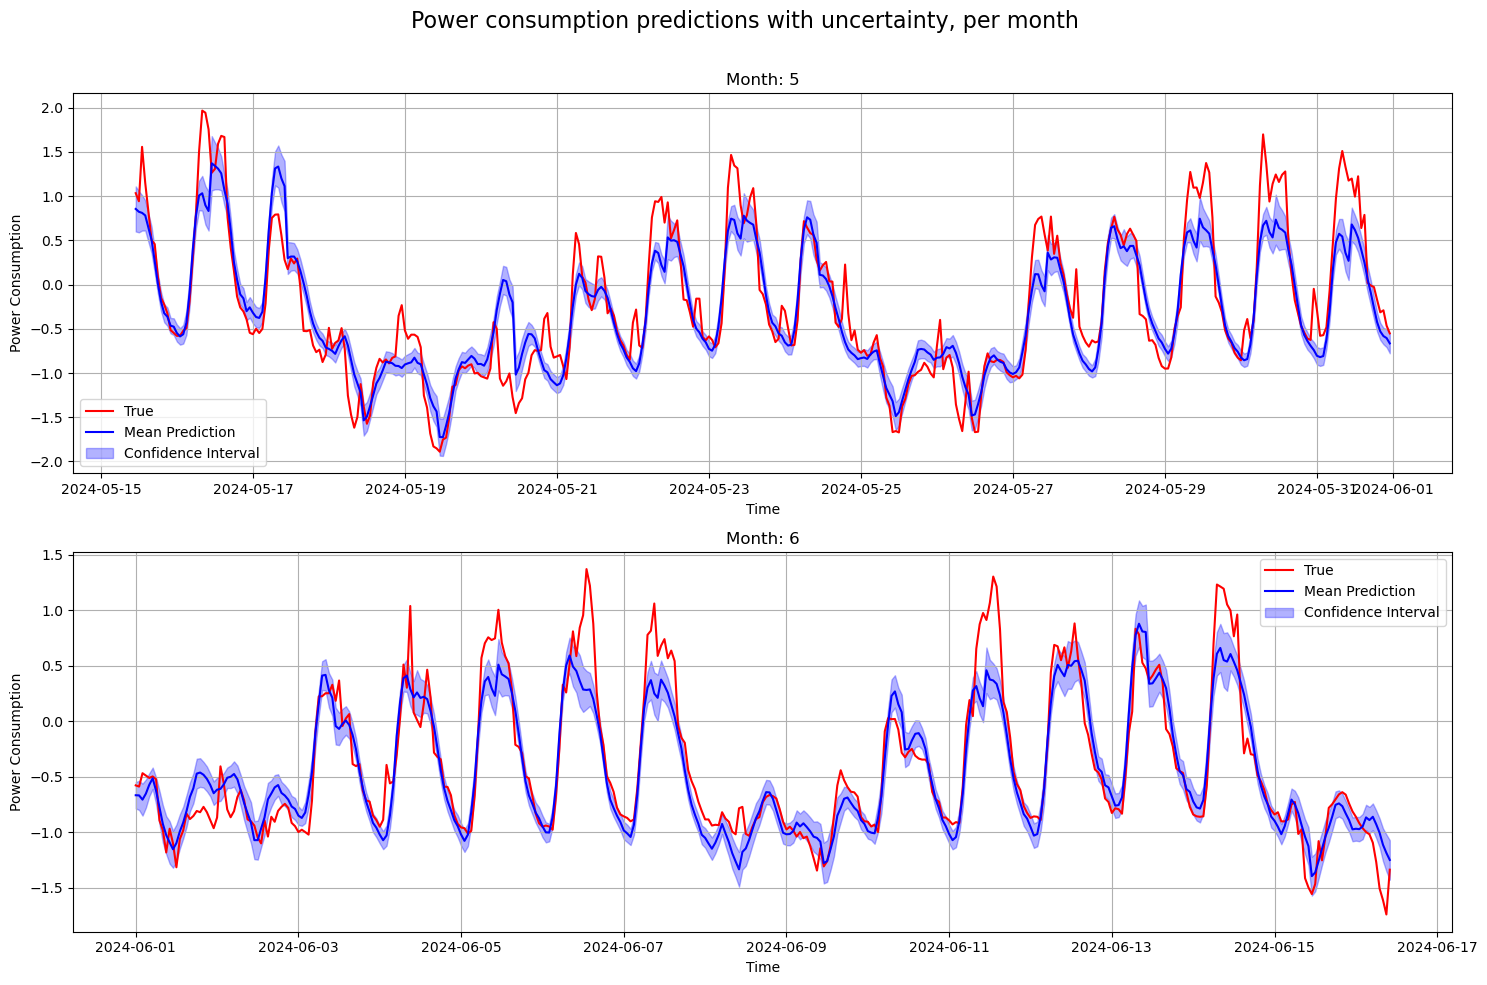

In [59]:
plot_results_with_uncertainty_by_month(mean_predictions, uncertainties, confidence_level, actuals, 'Power consumption predictions with uncertainty, per month')

In [60]:
models = ['TCN prediction at 10 am', 'TCN predictions at all time steps']
error_dict = {'model': models,
              'PICP': np.zeros(len(models)),
              'PINAW': np.zeros(len(models)),
    }
uncertainty_evaluation = pd.DataFrame(error_dict).set_index("model")

In [61]:
uncertainty_evaluation.loc[models[0], 'PICP'], uncertainty_evaluation.loc[models[0], 'PINAW'] = compute_picp_pinaw(actuals, mean_predictions - confidence_level * uncertainties, mean_predictions + confidence_level * uncertainties)
uncertainty_evaluation.loc[models[1], 'PICP'], uncertainty_evaluation.loc[models[1], 'PINAW'] = compute_picp_pinaw(y_true, mean_predictions_np - confidence_level * uncertainties_np, mean_predictions_np + confidence_level * uncertainties_np)
uncertainty_evaluation

,PICP,PINAW
model,,
TCN prediction at 10 am,0.41146,0.06673
TCN predictions at all time steps,0.37008,0.06225
